# Practicum 8: Demand - Adding insensitive consumers

We will include consumers that fail to respond to real-time prices, to examine how that impacts welfare and short/long-run outcomes. This will be in line with Borenstein and Holland (2005).

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

The code builds on Day 5 (tariff setting).

We first load relevant libraries, same as last session.

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

Remember to set your path correctly:

In [209]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day8/practicum/"

## Building the model

We load the same data as last week, and also clean it up to simplify it further and create the demand and import curves. We annualize fixed costs for new plants.

In [210]:
TECHS = ["hydronuc","gas1","gas2","gas3","newgas","wind","solar"]
INV_TECHS = ["newgas","wind","solar"]
RES_TECHS = ["wind","solar"]

In [211]:
def load_and_prepare(dirpath: str):

    dfclust = pd.read_csv(f"{dirpath}/data_jaere_clustered.csv")
    tech = pd.read_csv(f"{dirpath}/data_technology.csv")

    # Re-scaling weights: multiply by 8.76 and normalize (so that we can interpret it as annual revenue in million USD)
    dfclust["weights"] = 8.76 * dfclust["weights"] / dfclust["weights"].sum()
   

    # Calibrate imports: imports = am + bm * price
    elas = np.array([0.1, 0.2, 0.5, 0.3])
    dfclust["bm"] = elas[3] * dfclust["imports"] / dfclust["price"]
    dfclust["am"] = dfclust["imports"] - dfclust["bm"] * dfclust["price"]

    # Set index names for tech
    tech.index = TECHS
    
        # Annualization factor and fixed costs
    afactor = (1 - (1 / (1.05**20.0))) / 0.05
    tech["F"]  = tech["F"]  / afactor

    return dfclust, tech

dfclust, tech = load_and_prepare(dirpath)

## Adding insensitive demand to the problem

To include demand, we will separate the price that consumers pay from the price that the wholesale market sets. We define a variable "tariff" that is what consumers pay any hour of the day.

We also allow alpha to determine the share of "insensitive" consumers. We can see how the investment changes as we modify "alpha".

By popular demand, this code also include three different sectors with different elasticities and degrees of sensitivity.

In [212]:
def clear_market_invest(data, tech, ng_price=3.5, tax=0.0, tariff=[40.0, 40.0, 40.0], 
            elas = [.1, .2, .5, .3], alpha = [1.0, 1.0, 1.0],
            Kmax=50.0, solver_name="ipopt"):
    """
    Welfare max with endogenous investment (NLP)
    """
    T = len(data)
    S = 3 # demand segments

    # plain python lookups (no Params)
    c = {k: float(tech.at[k, "c"]) for k in TECHS}
    if "heatrate" in tech.columns:
        for k in ["gas1","gas2","gas3","newgas"]:
            if k in tech.index:
                c[k] = float(tech.at[k, "heatrate"]) * float(ng_price)

    e = {k: float(tech.at[k, "e"]) for k in TECHS} if "e" in tech.columns else {k: 0.0 for k in TECHS}
    F = {k: float(tech.at[k, "F"]) for k in TECHS} if "F" in tech.columns else {k: 0.0 for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3"] if "capUB" in tech.columns and k in tech.index}

    # assume T = number of rows (time), S = number of demand segments
    a = np.zeros((T, S))
    b = np.zeros((T, S))

    p = np.asarray(data["price"])  # or data.price if it's an object with attributes

    # Helper to keep things readable
    def calibrate_linear_demand(q, elasticity, price):
        """
        Calibrate q = a - b*price with constant elasticity at the observed point:
        elasticity = (dq/dp) * (p/q)  =>  dq/dp = elasticity * (q/p)
        We store slope 'b' (positive) so demand is q = a - b*p.
        """
        q = np.asarray(q)
        slope = elasticity * q / price          # pointwise dq/dp (likely negative)
        slope = np.mean(slope) * np.ones_like(q) # make slope constant over t
        intercept = q + slope * price            # because q = a - b*p and slope is dq/dp
        return intercept, slope

    # Residential 
    a[:, 0], b[:, 0] = calibrate_linear_demand(
        q=data["q_residential"], elasticity=elas[0], price=p
    )

    # Commercial 
    a[:, 1], b[:, 1] = calibrate_linear_demand(
        q=data["q_commercial"], elasticity=elas[1], price=p
    )

    # Industrial 
    a[:, 2], b[:, 2] = calibrate_linear_demand(
        q=data["q_industrial"], elasticity=elas[2], price=p
    )

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.S = RangeSet(0, S-1)
    m.I = Set(initialize=TECHS, ordered=False)
    m.J = Set(initialize=INV_TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, m.S, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q     = Var(m.T, m.I, domain=NonNegativeReals)
    m.costs = Var(m.T, domain=Reals)
    m.gs    = Var(m.T, domain=Reals)

    m.K      = Var(m.J, bounds=(0.0, float(Kmax)))  # capacity investments

    # Objective: gross surplus - variable costs - fixed costs
    m.obj = Objective(
        expr=sum(data.weights[t] * (m.gs[t] - m.costs[t]) for t in m.T)
             - sum(F.get(k) * m.K[k] for k in m.J),
        sense=maximize
    )

    # Market clearing
    m.demand_curve  = Constraint(m.T, m.S, rule=lambda m,t,s: 
        m.demand[t,s]  == a[t,s] - b[t,s] * (alpha[s] * m.price[t] + (1.0 - alpha[s]) * tariff[s]))
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: sum(m.demand[t, s] for s in m.S)  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Surplus + costs
    m.surplus_def = Constraint(
        # Note: now surprlus only matters for sensitive households (rest fixed)
        m.T, rule = lambda m,t:  m.gs[t] == 
        sum(alpha[s]*((b[t,s] * m.price[t]) * (a[t,s] -  b[t,s] * m.price[t]) / b[t,s] 
                      + ((a[t,s] - b[t,s] * m.price[t])**2) / (2.0 * b[t,s])) for s in m.S)
    )
    m.cost_def = Constraint(
        m.T, rule = lambda m,t: m.costs[t] == sum((c[k] + float(tax) * e[k]) * m.q[t,k] for k in m.I)
                           + (m.imports[t] - data.am[t])**2 / (2.0 * data.bm[t])
    )

    # Capacity constraints
    m.cap_hydronuc = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= data.hydronuc[t] for t in m.T})
    if capUB:
        m.cap_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                  expr={(t,k): m.q[t,k] <= capUB[k] for t in m.T for k in capUB})

    m.cap_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] <= m.K["newgas"] for t in m.T})
    m.cap_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   <= m.K["wind"]  * data.wind_cap[t]  for t in m.T})
    m.cap_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  <= m.K["solar"] * data.solar_cap[t] for t in m.T})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term.lower() in ("optimal", "locallyoptimal", "locally_optimal", "locally optimal"):
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t,s])  for t in m.T for s in m.S]).reshape((T, S))
        imports = np.array([value(m.imports[t]) for t in m.T])
        q = {k: np.array([value(m.q[t,k]) for t in m.T]) for k in TECHS}
        K = {k: float(value(m.K[k]))           for k in INV_TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr) / np.sum(w_arr))

        objective = float(np.sum([data.weights[t] * (value(m.gs[t]) - value(m.costs[t])) for t in m.T])
                        - F.get("newgas", 0.0) * K["newgas"]
                        - F.get("wind",   0.0) * K["wind"]
                        - F.get("solar",  0.0) * K["solar"])
        
        w_arr = data["weights"].to_numpy()
        emissions = sum(w_arr[t] * sum(e[i] * q[i][t] for i in m.I) for t in m.T)
        avg_price = float(np.sum(price * w_arr)/np.sum(w_arr))
        demand_insen = [a[t, :] - b[t, :] * tariff for t in range(T)]
        num = (w_arr[:, None] * price[:, None] * demand_insen).sum(axis=0)
        den = (w_arr[:, None] * demand_insen).sum(axis=0)
        avg_customer_cost = num / den

        # cost accounting
        gen_cost_t = np.array([value(m.costs[t])   for t in m.T])
        imp_cost_t = (imports - data["am"].to_numpy()) ** 2 / (2.0 * data["bm"].to_numpy())
        total_cost = float(np.sum(w_arr * (gen_cost_t + imp_cost_t))) + F.get("newgas", 0.0) * K["newgas"] +  F.get("wind",   0.0) * K["wind"] +  F.get("solar",  0.0) * K["solar"]

        return {"status": term, "avg_price": avg_price, "price": price,
                "quantity": q, "imports": imports, "avg_customer_cost": avg_customer_cost,  "total_cost": total_cost,
                "demand": demand, "cost": total_cost, "objective": objective, "K": K, "emissions": emissions}

    return {"status": term}


In [213]:
res_sensitive = clear_market_invest(dfclust, tech, ng_price=3.5, alpha=[1.0, 1.0, 1.0])

In [214]:
res_sensitive["avg_customer_cost"]

array([33.29755455, 33.32863139, 34.56719396])

In [215]:
res_insensitive = clear_market_invest(dfclust, tech, ng_price=3.5, alpha=[0.1, 0.1, 0.1], tariff=res_sensitive["avg_customer_cost"])

In [216]:
res_insensitive["avg_customer_cost"]

array([35.02143549, 34.9013057 , 37.24577261])

We can see that having inattentive consumers makes costs higher. We can also see there is further need for investment.

In [217]:
res_sensitive["K"]

{'newgas': 5.955219170333143,
 'wind': -8.540889949827964e-09,
 'solar': -9.933335474962674e-09}

In [218]:
res_insensitive["K"]

{'newgas': 7.386339885974403,
 'wind': -7.80005526051402e-09,
 'solar': -9.91607384301638e-09}

### Now we compute the equilibrium tariff

We create a function that will do the loop and return the average price that we need to charge consumers of each kind.

In [ ]:
def clear_market_equilibrium(data, tech, ng_price=3.5, tax=0.0,
                             tariff = [40.0,40.0,40.0], elas = [.1, .2, .5, .3], alpha = [0.2, 0.3, 0.8],
                             tol=1e-4, max_iter=10):
    current_diff = 1.0
    guess = tariff
    it = 0

    while current_diff > tol and it < max_iter:
        res = clear_market_invest(
            data, tech,
            ng_price=ng_price, tax=tax, tariff=guess, elas=elas, alpha=alpha
        )

        if res["status"] == "optimal":
            newguess = res["avg_customer_cost"]
        else:
            print(f"Model is {res['status']} at {guess}")
            return res

        current_diff = sum((guess - newguess) ** 2)
        guess = newguess
        it += 1

    # solve at (approx) equilibrium to return results
    res = clear_market_invest(
        data, tech,
        ng_price=ng_price, tax=tax, tariff=guess, elas=elas, alpha=alpha
    )
    return res

In [220]:
res_eq = clear_market_equilibrium(dfclust,tech, alpha=[0.1, 0.1, 0.1])

In [221]:
print(res_eq["avg_customer_cost"])

[35.03026143 34.92655339 37.51785263]


In [222]:
res_eq["K"]

{'newgas': 7.02966292485785,
 'wind': -7.850735807045364e-09,
 'solar': -9.916076489522443e-09}

## Does it help to have attentive consumers?

We visualize the impact of the policy of changing residential customers sensitivity.

We can plot the costs (or prices) of electricity for several values of alpha. This can take a while to compute.

In [230]:
# We create a grid to produce results under different responsiveness
share_alpha = np.arange(0.0, 1.0 + 1e-9, 0.2)   # 0.0,0.2,...,1.0
tax_grid    = np.arange(0.0, 30.0 + 1e-9, 15.0) # 0,15,30
elas_grid   = np.arange(0.1, 0.5 + 1e-9, 0.2)   # 0.1,0.3,0.5

rows = []
for a in share_alpha:
    for t in tax_grid:
        for e in elas_grid:
            res = clear_market_equilibrium(
                dfclust, tech,
                ng_price=3.5,
                alpha=[a, a, a],
                elas=[e, 0.2, 0.5, 0.3],
                tax=t
            )
            rows.append({
                "alpha": float(a),
                "elas": float(e),
                "tax": float(t),
                "tariff_res": float(res["avg_customer_cost"][0]),
                "tariff_com": float(res["avg_customer_cost"][1]),
                "tariff_ind": float(res["avg_customer_cost"][2]),                                
                "gas_gw": float(res["K"]["newgas"]),
                "wind_gw": float(res["K"]["wind"]),
                "solar_gw": float(res["K"]["solar"]),
                "emissions": float(res["emissions"])
            })

dataPolicy = pd.DataFrame(rows)

In [224]:
dataPolicy.head(20)

,alpha,elas,tax,tariff_res,tariff_com,tariff_ind,gas_gw,wind_gw,solar_gw
0,0.0,0.1,0.0,36.106841,36.087820,40.075169,7.720611e+00,-6.986188e-09,-9.910062e-09
1,0.0,0.3,0.0,38.866490,36.543475,41.196100,9.116055e+00,-7.766037e-09,-9.907218e-09
2,0.0,0.5,0.0,43.352608,36.963339,42.160912,9.884402e+00,-7.487915e-09,-9.908721e-09
3,0.0,0.1,15.0,40.159075,40.583180,45.053222,3.425521e+00,1.242662e+01,-9.878969e-09
4,0.0,0.3,15.0,43.446900,41.209955,46.909097,4.515434e+00,1.092471e+01,-9.872289e-09
5,0.0,0.5,15.0,48.787300,41.513756,47.927455,6.042200e+00,7.674309e+00,-9.877461e-09
6,0.0,0.1,30.0,42.325239,43.208340,48.460441,9.496253e-01,2.054892e+01,-9.536695e-09
7,0.0,0.3,30.0,45.845464,43.669070,50.462043,2.290874e+00,1.764100e+01,-9.371270e-09
8,0.0,0.5,30.0,52.813099,43.865222,51.960611,3.527079e+00,1.284790e+01,-9.472688e-09
9,0.2,0.1,0.0,34.507649,34.394341,36.467691,6.724251e+00,-8.097516e-09,-9.921824e-09


We can plot how wind investment is affected by having "flexible demand".

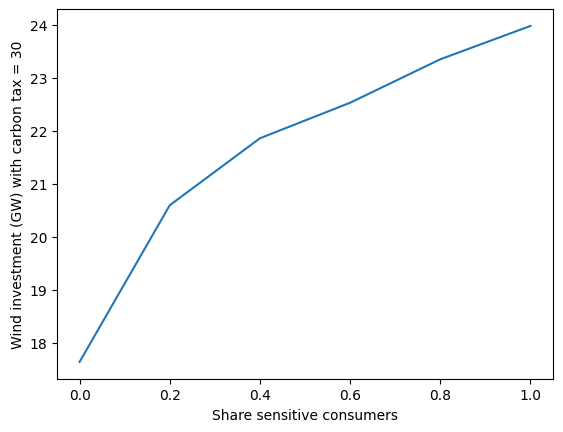

In [234]:
# We select a certain "slice" of the data to plot
# Note: we round to avoid floating point issues

carbontax = 30
elasticity = 0.3

tax1 = dataPolicy[(dataPolicy["tax"].round(0) == carbontax) & (dataPolicy["elas"].round(1) == elasticity)].copy()
tax1 = tax1.sort_values("alpha")

plt.figure()
plt.plot(tax1["alpha"], tax1["wind_gw"])
plt.xlabel("Share sensitive consumers")
plt.ylabel(f"Wind investment (GW) with carbon tax = {carbontax}")
plt.show()

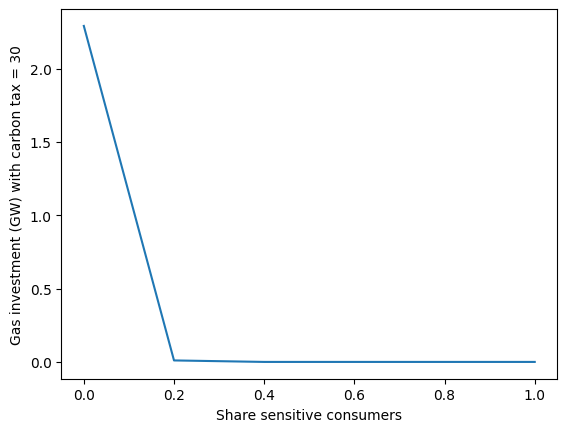

In [235]:
plt.figure()
plt.plot(tax1["alpha"], tax1["gas_gw"])
plt.xlabel("Share sensitive consumers")
plt.ylabel(f"Gas investment (GW) with carbon tax = {carbontax}")
plt.show()

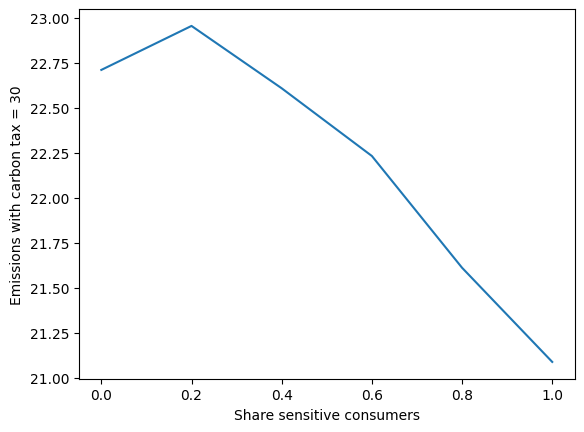

In [236]:
plt.figure()
plt.plot(tax1["alpha"], tax1["emissions"])
plt.xlabel("Share sensitive consumers")
plt.ylabel(f"Emissions with carbon tax = {carbontax}")
plt.show()

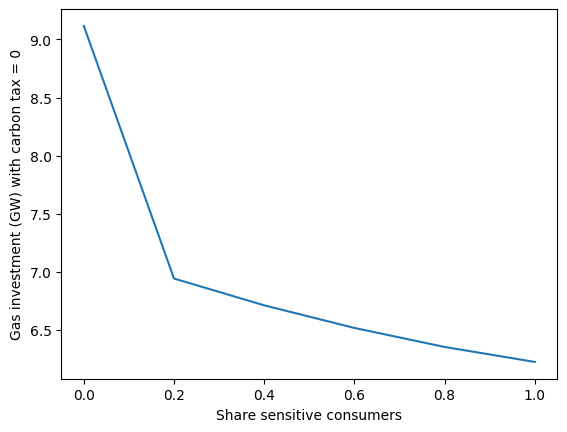

In [229]:
tax2 = dataPolicy[(dataPolicy["tax"].round(0) == 0) & (dataPolicy["elas"].round(1) == elasticity)].copy()
tax2 = tax2.sort_values("alpha")

plt.figure()
plt.plot(tax2["alpha"], tax2["gas_gw"])
plt.xlabel("Share sensitive consumers")
plt.ylabel(f"Gas investment (GW) with carbon tax = 0")
plt.show()

## Follow-up exercises

1. What take aways do you get from the above visualization?

2. Consider an energy savings technology. How could it be added to the model? What would be the challenges in calibrating it?

3. The underlying elasticity of households can limit the usefulness of making households price-sensitive. What happens when you also make them more elastic, e.g., thanks to technological gadgets?
   
4. In our tech file, solar power is expensive. Make it cheaper and see what happens to investment with/without flexible demand.